# Arctic-EDS Data Preparation - Wet Days Per Year
## Objective

This notebook will execute the necessary preprocessing of data prior to a Rasdaman ingest. The scope of this notebook will cover a single "plate" from the original Environmental Atlas of Alaska. The data generated here will constitute a single dataset and correspond to single coverage in Rasdaman.

![img](wet_days_per_year.png)

The old-school Atlas pictured above defines a "wet day" as day with 0.1 inch (about 2.5 mm) or more precipitation. Values in the original plate range from around 20 to over 200. However, a more common "climate indicator" value is 1.0 mm, and is the value used as the default for thresholding this particular dataset. The goal is to create a dataset of GeoTIFFs in which each file represents the count of the the number of wet days in a single year. There will be one file per year.

## Source Data Details
The data source for the new coverages is the 20km WRF-downscaled climate data:

- Data Portal entry: [Historical and Projected Dynamically Downscaled Climate Data for the State of Alaska and surrounding regions at 20km spatial resolution and hourly temporal resolution](https://catalog.snap.uaf.edu/geonetwork/srv/eng/catalog.search#/metadata/7825535c-edff-4a82-89f3-9183e6cb2b42)
- This dataset has daily total precipitation values that can be used to compute the number of days with precipitation totals greater than or equal to some threshold.
- Each file contains a year's worth of daily total precipitation values for single model and scenario.
- 20 km spatial resolution.
- Range: 1970-2100
- Models: ERA-Interim (1979-2015), GFDL-CM3, NCAR-CCSM4
- Scenarios: historical, and RCP 8.5
- There are leap year indices, but no leap year data. The leap day (Feb. 29) data are all `nans` and there no data for these time slices in the original hourly data in the first place. We are counting occurences of array values greater than the threshold (0.1), so these `nan` values will not impact our results. Leap days won't jam up this calculation and so leap years can be effectively ignored. 
- The start and end years for the ERA-Interim data don't have 365 days! The start year (1979) has only 364 days because the time series began on January 2. The end year (2015) has 302 days because the time series ended sometime in October. We reduce the historical period to the thirty year climatology for 1980-2009 to better match the other Arctic-EDS maps.

## Pipeline Steps
0. Setup: configure environment: directories, environment variables, and import all the needed libraries. Execute the setup code cell before any other step!
1. Fetch Data: Grab data if not currently available locally and establish filepaths for processing.
2. Spec Output: Create profiles and objects for writing the new data to disk.
3. Process: threshold the data, sum the number of days meeting or exceeding the threshold, and write dataset to disk.
4. Crop it
5. QC it
6. Archive it

## Step 0: Setup

In [1]:
import os
import shutil
import pandas as pd
import rasterio as rio
import xarray as xr
import numpy as np
import threading
import concurrent.futures
import random
import matplotlib.pyplot as plt
from subprocess import call
from pyproj.crs import CRS
from pathlib import Path
from rasterio.plot import show
from tqdm.contrib.concurrent import process_map

# general config
COPY_SOURCE = False
COPY_OUTPUTS_TO_ARCHIVE = False
os.environ["WET_DAY_THRESHOLD_MM"] = (os.getenv("WET_DAY_THRESHOLD_MM") or "1.0")
os.environ["NCORES"] = (os.getenv("NCORES") or "32")
os.environ["AK_COAST_SHP"] = (os.getenv("AK_COAST_SHP") or "/home/UA/cparr4/repos/geospatial-vector-veracity/vector_data/polygon/boundaries/alaska_coast_simplified/Alaska_Coast_Simplified_Polygon.shp")
shapefile_cropper = os.getenv("AK_COAST_SHP")

# directory config
os.environ["PROJECT_DIR"] = "/atlas_scratch/cparr4/wet_days"
os.environ["WRF_SRC_DIR"] = "/rcs/project_data/wrf_data/daily/pcpt"
os.environ["WRF_DST_DIR"] = "/atlas_scratch/cparr4/wet_days/wrf_daily_pcpt"
os.environ["OUTPUT_DIR"] = "/atlas_scratch/cparr4/wet_days/outputs"
os.environ["ARCHIVE_DIR"] = "/workspace/Shared/Tech_Projects/Arctic_EDS/project_data/rasdaman_datasets/wet_days_per_year"

# set the environment variables and create directories and Path objects
wrf_src_path = Path(os.environ["WRF_SRC_DIR"])

wrf_dst_path = Path(os.environ["WRF_DST_DIR"])
wrf_dst_path.mkdir(parents=True, exist_ok=True)

output_path = Path(os.environ["OUTPUT_DIR"])
output_path.mkdir(parents=True, exist_ok=True)

archive_path = Path(os.environ["ARCHIVE_DIR"])
archive_path.mkdir(parents=True, exist_ok=True)

In [2]:
!ls $PROJECT_DIR

outputs  wrf_daily_pcpt


## 1 - Fetch Data
We don't have to download any external data - these are on our file system. These were intially fetched via
```sh
cp -r /rcs/project_data/wrf_data/daily/pcpt /atlas_scratch/cparr4/wet_days/wrf_daily_pcpt
```
but we can include a fetch a function to grab data if we need it. These daily precip data total 18 GB so fetching them isn't a big lift.

Also, because wet days per year is inherently a count of days, we should only use years that have the full number of days in them, i.e. no partial years with only 302 days. This means that for the historical ERA-Interim data we will truncate to the thirty-year 1980 to 2009 time period.


In [3]:
print("Executing Step 1 (Fetch Data)...\n")

fps = [x for x in wrf_src_path.rglob("*.nc")]

if COPY_SOURCE:
    new_fps = [wrf_dst_path / ''.join(x.name) for x in fps]
    print(f"Copying {len(new_fps)} netCDF files to {wrf_dst_path}")
    for src, dst in zip(fps, new_fps):
        shutil.copy(src, dst)
else:
    print("No files were copied from the source directory to the project directory.\n")
    
project_fps = sorted([x for x in wrf_dst_path.rglob("*.nc")])

assert(len(fps) == len(project_fps))

era_interim_fps = sorted([x for x in project_fps if "interim" in x.name.lower()])[1:31]
ccsm4_rcp85_fps = [x for x in project_fps if ("ccsm4" in x.name.lower() and "rcp" in x.name.lower())]
cm3_rcp85_fps = [x for x in project_fps if ("cm3" in x.name.lower() and "rcp" in x.name.lower())]

assert(len(era_interim_fps) == 30)
assert(len(cm3_rcp85_fps) == len(ccsm4_rcp85_fps))

fps_to_process = era_interim_fps + ccsm4_rcp85_fps + cm3_rcp85_fps

print(f"Example input filename from the project directory:\n {project_fps[100]}\n")

print("Step 1 (Fetch Data) Complete.\n")

Executing Step 1 (Fetch Data)...

No files were copied from the source directory to the project directory.

Example input filename from the project directory:
 /atlas_scratch/cparr4/wet_days/wrf_daily_pcpt/pcpt/pcpt_daily_wrf_GFDL-CM3_rcp85_2032.nc

Step 1 (Fetch Data) Complete.



## 2 - Spec Output
Generate a raster creation profile based on the WRF input data proj string. This will allow to write GeoTIFFs of wet days with a common structure. We have integer values (number of days) that should be bound between 0 and 365 (inclusive) so an `int16` data type is a good choice because it will cover the range of the data and permit a `-9999` no data value. `profile` will be a global variable used when we actually create the entire dataset.

In [4]:
with xr.open_dataset(fps_to_process[0]) as ds:
    crs = CRS.from_proj4(ds.attrs["proj_parameters"])
    width = ds.xc.values.shape[0]
    height = ds.yc.values.shape[0]
    transform = rio.transform.from_bounds(
        ds.xc.values.min(), 
        ds.yc.values.min(), 
        ds.xc.values.max(), 
        ds.yc.values.max(), 
        width,
        height,
    )

profile = {
    "driver": "GTiff",
    "crs": crs,
    "transform": transform,
    "width": width,
    "height": height,
    "count": 1,
    "dtype": "int16",
    "nodata": -9999,
    "tiled": False,
    "compress": "lzw",
    "interleave": "band",
}

## 3 - Threshold the data
Nothing exotic here: threshold the data and count the numbers of days meeting or exceeding that threshold. Write a GeoTIFF. I've split this out into small functions, and then we'll use the `process_map` from `tqdm.contrib.concurrent` to execute the dataset creation in parallel across a single node. The `tqdm` implentation is a thin progress-bar wrapper around Python's `concurrent.futures` (in the standard library) which is a high-level interface for asynchronously executing callables. `process_map` implements the ProcessPoolExecutor class to bypass the GIL. 

In [5]:
def count_wet_days_per_year(fp):
    """Open a file containing a year's worth of daily precipitation data and compute the number of days where the
    total preicpitation meets or exceeds the threshold.
    """
    
    with xr.open_dataset(fp) as ds:
        wet_day_arr = ds.pcpt.values >= float(os.getenv("WET_DAY_THRESHOLD_MM"))
    wet_days_per_year_arr = wet_day_arr.sum(axis=0)
    
    return wet_days_per_year_arr


def write_wet_days_per_year_geotiff(out_fp, arr):
    with rio.open(out_fp, "w", **profile) as dst:
        dst.write(arr, 1)


def run_wet_days_per_year(args):
    fp, out_fp = args
    write_wet_days_per_year_geotiff(out_fp, count_wet_days_per_year(fp))
    
        
def make_wet_days_per_year_dataset(wrf_fps):
    """Create a wet days per year dataset consisting of annual GeoTIFFs that the store the count of the
    number of wet days in the specified year.
    
    Args:
        wrf_fps (list): list of daily 20 km WRF precip data files to use
    """
    args = []
    for fp in wrf_fps:
        model = fp.name.split("_")[3]
        year = fp.name.split(".")[0].split("_")[-1]
        args.append((
            fp,
            output_path.joinpath(f"wet_days_per_year_{model}_{year}.tif"),
        ))

    process_map(run_wet_days_per_year, args, max_workers=int(os.getenv("NCORES")))
    
    return

In [6]:
make_wet_days_per_year_dataset(fps_to_process)

  0%|          | 0/220 [00:00<?, ?it/s]

In [7]:
!ls $OUTPUT_DIR | head -n 10

wet_days_per_year_ERA-Interim_1980.tif
wet_days_per_year_ERA-Interim_1981.tif
wet_days_per_year_ERA-Interim_1982.tif
wet_days_per_year_ERA-Interim_1983.tif
wet_days_per_year_ERA-Interim_1984.tif
wet_days_per_year_ERA-Interim_1985.tif
wet_days_per_year_ERA-Interim_1986.tif
wet_days_per_year_ERA-Interim_1987.tif
wet_days_per_year_ERA-Interim_1988.tif
wet_days_per_year_ERA-Interim_1989.tif


## 4 - Crop Dataset to the extent of Alaska's terrestrial area.

We want to mask the data to the footprint of Alaska using the "Alaska Coast Simplified" shapefile from the ua-snap/geospatial-vector-veracity repo. We pass this task to `gdalwarp` using python to parallelize.

Using an environment variable for the path to the Alaska coast shapefile should make it easy to grab that shapefile from different locations and enable testing of different crop footprints for data availability at coastal locations.

In [9]:
def mask_to_ak():
    args = []
    for fp in output_path.glob("*.tif"):
        out_fp = output_path.joinpath(fp.name.replace(".tif", "_masked.tif"))
        command = [
            "gdalwarp",
            "-t_srs",
            "EPSG:3338",
            "-co",
            "COMPRESS=LZW",
            str(fp),
            str(out_fp),
            "-cutline",
            shapefile_cropper,
            "-crop_to_cutline",
            # next two lines require pixels to not touch
            #  the cutline polygon at all to be masked off
            "-wo",
            "CUTLINE_ALL_TOUCHED=TRUE",
            "-q",
        ]
        args.append(command)
        
    process_map(call, args, max_workers=int(os.getenv("NCORES")))
    
    # overwrite existing processed files with masked / cropped files
    for fp in list(output_path.glob("*masked.tif")):
        fp.rename(output_path.joinpath(fp.name.replace("_masked.tif", ".tif")))
        
    return

In [10]:
mask_to_ak()

  0%|          | 0/220 [00:00<?, ?it/s]

## 5 QC
Check metadata conformity, check data are within expected range, check histograms, and plot some samples

In [11]:
!ls $OUTPUT_DIR | head -n 10

wet_days_per_year_ERA-Interim_1980.tif
wet_days_per_year_ERA-Interim_1981.tif
wet_days_per_year_ERA-Interim_1982.tif
wet_days_per_year_ERA-Interim_1983.tif
wet_days_per_year_ERA-Interim_1984.tif
wet_days_per_year_ERA-Interim_1985.tif
wet_days_per_year_ERA-Interim_1986.tif
wet_days_per_year_ERA-Interim_1987.tif
wet_days_per_year_ERA-Interim_1988.tif
wet_days_per_year_ERA-Interim_1989.tif


### Verify the correct number of files were generated
There should a 30 year historical baseline, plus two projections containing 95 years of data each, for a total of 220 files. 

In [12]:
output_fps = sorted([x for x in output_path.rglob("*.tif")])

assert(len(output_fps) == 220)

### Verify metadata is constant across the dataset
Each geotiff must have identical header information, spatial extent, coordinate reference system, nodata value, compression, and spatial resolution

In [13]:
def metadata_check(directory):
    all_meta = []
    fps = [x for x in directory.glob("*.tif")]
    read_lock = threading.Lock()

    def process(fp):
        src = rio.open(fp)
        with read_lock:
            profile = src.profile
            all_meta.append(profile)
    
    # We map the process() function over the list of files
    with concurrent.futures.ThreadPoolExecutor(
        max_workers=int(os.getenv("NCORES"))
    ) as executor:
        executor.map(process, fps)

    return all_meta


In [14]:
meta = metadata_check(output_path)

In [15]:
assert(all([x == meta[0] for x in meta]) == True)

### Verify the dataset passes the eyeball test.
It is always good to verify that the data have visual integrity: bounds and data values / patterns look realistic, etc. These figures are a good way to share progress on a dataset with others as well.

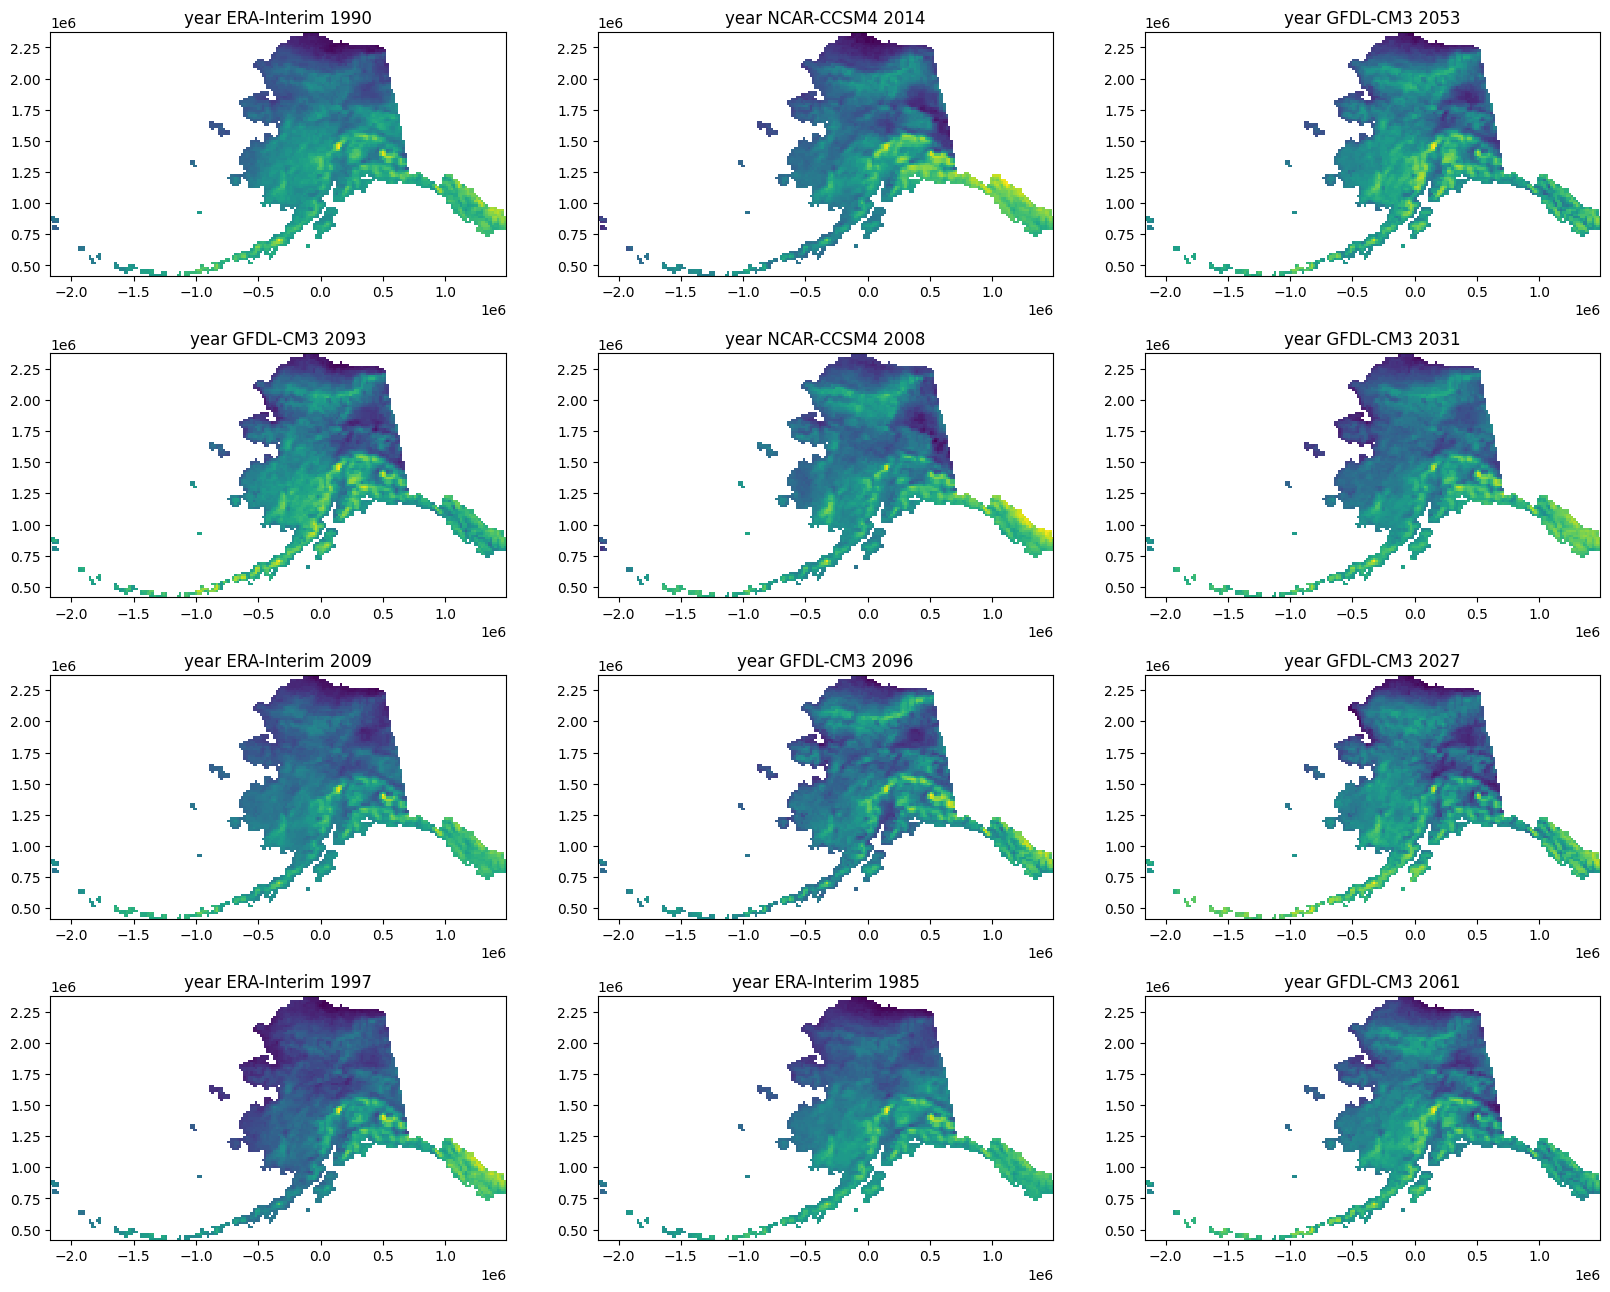

In [16]:
def plot_maps(out_dir, title_split_idx):
    fig, axs = plt.subplots(4, 3, figsize=(20, 16))

    out_fps = sorted(list(out_dir.glob("*.tif")))
    arrs = []
    titles = []
    for ax in axs.flatten():
        i = np.random.randint(len(out_fps))
        fp = out_fps[i]
        with rio.open(fp) as src:
            show(src, ax=ax, interpolation="none")
            arrs.append(src.read(1))
        title = " ".join(fp.name.split(".")[0].split("_")[title_split_idx:])
        ax.set_title(title)
        titles.append(title)

    plt.show()
    
    return arrs, titles
    
arrs, titles = plot_maps(output_path, 3)

These data look good to me: brighter values are wetter (more wet days per year) and these are concentrated in normally wet areas (mountains and SE Alaska). This dataset has some nice visual distinction between different models and years.

### Examine statistical distribution
Get a handle on the range and shape of the data. Look for outliers or unexpected distributions.

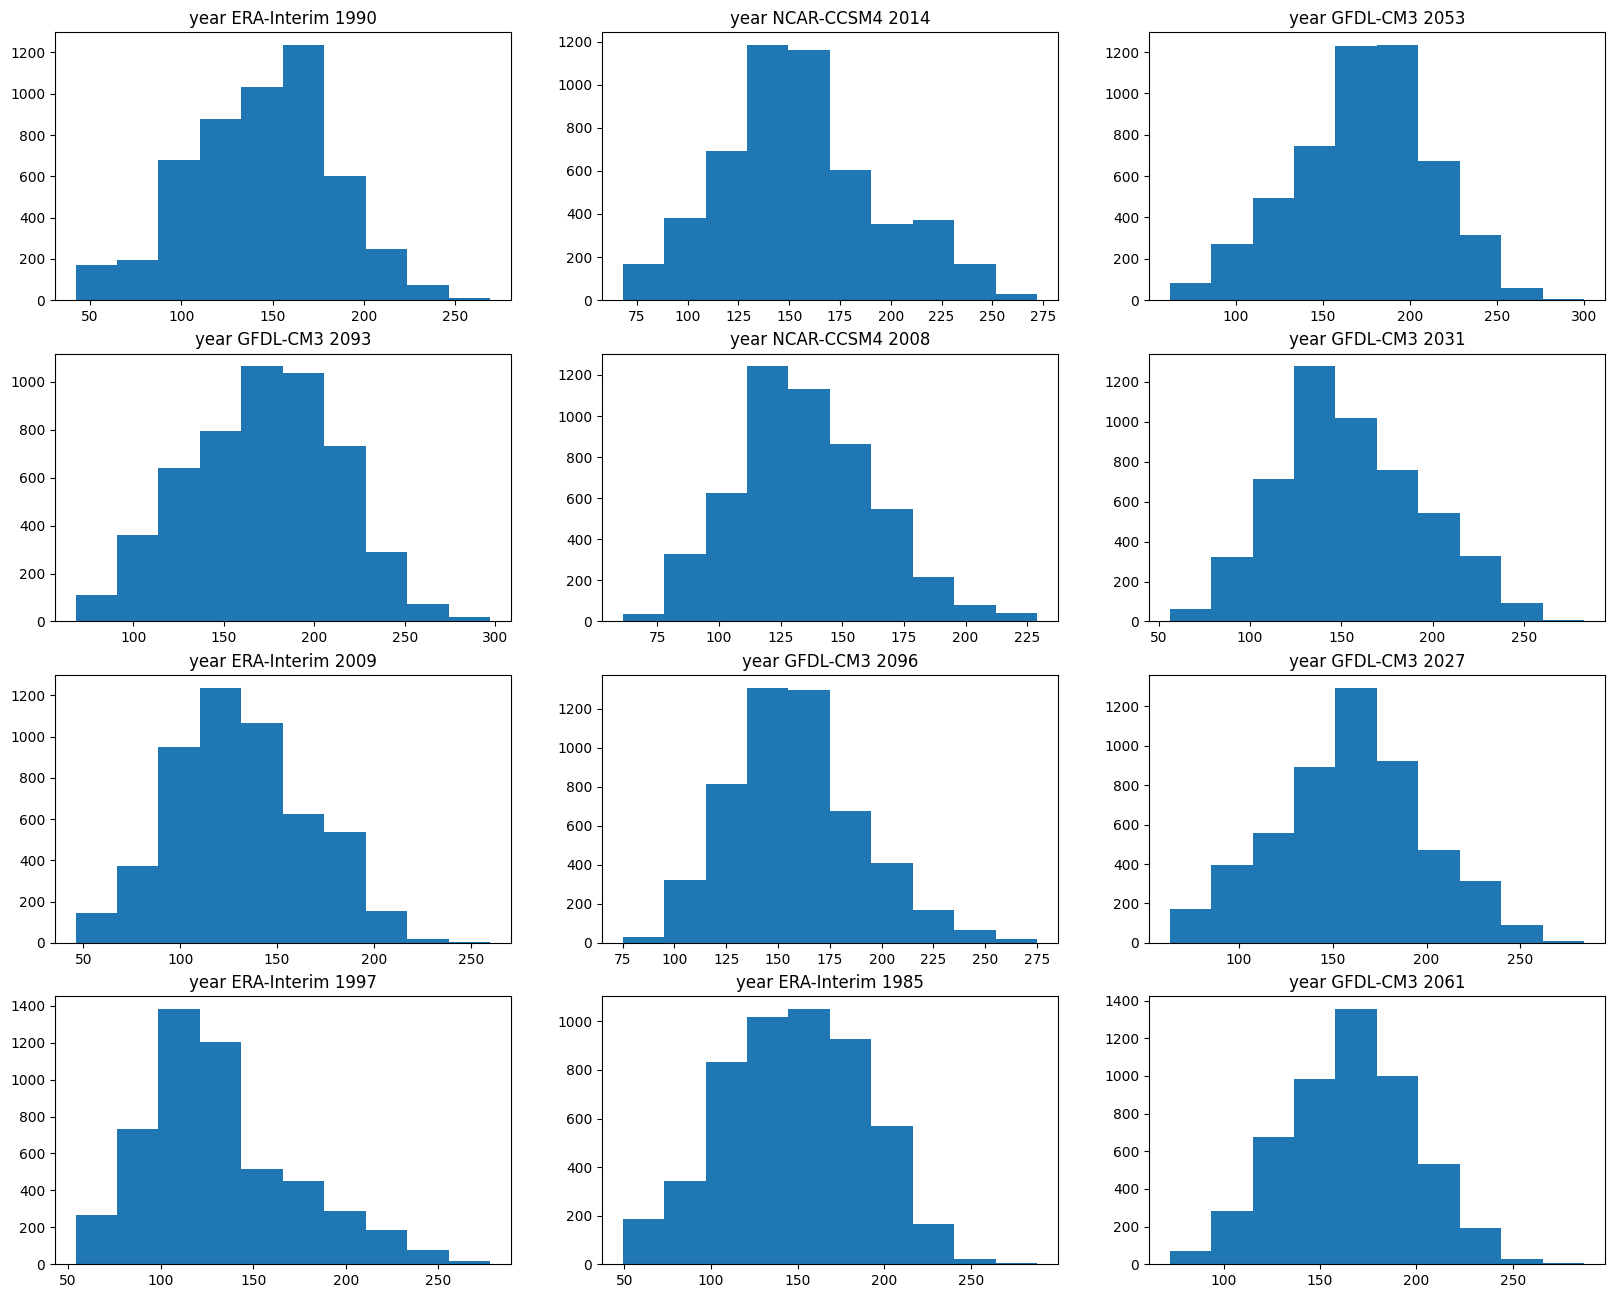

In [17]:
def plot_histograms(arrs, titles):
    fig, axs = plt.subplots(4, 3, figsize=(20, 16))
    for ax, arr, title in zip(axs.flatten(), arrs, titles):
        arr = arr.flatten()
        arr = arr[arr != -9999]
        ax.hist(arr)
        ax.set_title(title)

    plt.show()
    
plot_histograms(arrs, titles)

The data appear log-normalish and they are bound by the expected value range of 0 to 365 days.

## 6 Archive It
Stash the data in the *backed-up-Rasdaman-pot-of-SNAP-gold<sup>TM</sup>*
For the Arctic-EDS that's here: `/workspace/Shared/Tech_Projects/Arctic_EDS/project_data/rasdaman_datasets/` plus whatever was configured as the parent directory, like "wet_days_per_year"

In [18]:
if COPY_OUTPUTS_TO_ARCHIVE:
    archive_fps = [archive_path / ''.join(x.name) for x in output_fps]
    print(f"Copying {len(archive_fps)} files to {archive_path}...")
    for src, dst in zip(output_fps, archive_fps):
        shutil.copy(src, dst)
    assert(len([x for x in archive_path.rglob("*.tif")]) == len(output_fps))
else:
    print("No files were copied from the project output directory to the archive directory.")

No files were copied from the project output directory to the archive directory.


These data should now be ready to pull over to a Rasdaman server for the actual ingest process.